## Particle in Cell method for the one-dimensional two-counterstreaming plasma

In [1]:
import numpy as np
import scipy.linalg as la

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import animation, rc
from IPython.display import HTML

In [ ]:
def twoStreamPICsim(length=1.,
                    timeStep=0.1,
                    initStreamVelocity=0.1,
                    posPerturb_stddev=1/50,
                    velPerturb_stddev=.1/50,
                    qmRatio=.1,
                    numSteps=100, 
                    numCells=50, 
                    numParticles=100,
                    color1='r',
                    color2='b',
                    displayAnimation=True,
                    saveAnimation=False,
                    fps=25,
                    stepsPerFrame=1,
                    saveSimulation=False):
    cellSize = length / numCells
    fixedChargedDensity = numParticles * qmRatio / length
    
    # Decleare and pre-fill with zeros charge densities, potentials, el. fields in cells
    potentials = np.zeros((numSteps, numCells))
    elfields = np.zeros((numSteps, numCells))
    chargedensities = np.full((numSteps, numCells), fixedChargedDensity)
    
    # Decleare and pre-fill particles positions and velocities, and add small perturbations
    positions = np.zeros((numSteps, numParticles))
    positions[0] = np.linspace(0, length, numParticles)
    positions[0] += np.random.randn(numParticles) * posPerturb_stddev
    velocities = np.zeros((numSteps, numParticles))
    velocities[0] = ((np.arange(numParticles)%2)*2-1)*initStreamVelocity
    velocities[0] += np.random.randn(numParticles) * velPerturb_stddev
    
    # Call the function that runs the main simulation loop
    runSimulation(positions, velocities, potentials, elfields, chargedensities,
                  length, timeStep, cellSize, qmRatio, numSteps, numCells, numParticles)
    
    # Calculate total momentum and energies for all simulation time steps
    totalMomentum = np.sum(velocities, axis=1)
    totalKinEnergy = 0.5*np.sum(velocities**2, axis=1)
    totalPotEnergy = 0.5*cellSize*np.sum(elfields**2, axis=1)
    totalEnergy = totalKinEnergy + totalPotEnergy
    
    # Visualize the total momentum and energy evolution over time
    plt.plot(totalMomentum)
    plt.title("Total momentum of the system over time")
    
    plt.figure()
    plt.plot(totalEnergy)
    plt.title("Total energy of the system over time")
    
    # Create an interactive animation of the simulation and/or save it if desired
    if displayAnimation or saveAnimation:
        animateSimulation(positions, velocities, numParticles, length, initStreamVelocity, 
                      color1, color2, displayAnimation, fps, numSteps, stepsPerFrame)
        
    # Save the simulation data if desired
    if saveSimulation:
        saveSimulation(positions, velocities, totalMomentum, totalKinEnergy, totalPotEnergy, totalEnergy)

In [ ]:
def animateSimulation(positions, velocities, numParticles, length, initStreamVelocity, 
                      color1, color2, displayAnimation, fps, numSteps, stepsPerFrame):
    mpl.rcParams.update(mpl.rcParamsDefault)
    mpl.rcParams['animation.embed_limit'] = 2**64

    fig, ax = plt.subplots()
    colors = np.array([(color1 if i%2==0 else color2) for i in range(numParticles)])
    scatterPlot = ax.scatter(0, 0, s=4.)

    # Set up axis limits for both static and dynamic cases
    ax.set_xlim(0, length)
    ax.set_ylim(-initStreamVelocity*6, initStreamVelocity*6)
    dynamicAxisLimits = False
    axisLimitWspace = 1.2
    minVelocities = np.min(velocities, axis=1) * axisLimitWspace
    minVelocities = minVelocities * (minVelocities<0)
    maxVelocities = np.max(velocities, axis=1) * axisLimitWspace
    maxVelocities = maxVelocities * (maxVelocities>0)
    
    # Function that gets called at each frame to update the figure
    def animateStep(frame):
        scatterPlot.set_offsets(np.vstack([positions[frame],velocities[frame]]).T)
        scatterPlot.set_color(colors)
        
        # Allow for dynamic, on-the-fly resizing of the figure
        if dynamicAxisLimits and frame%10==0:
            ax.set_ylim(minVelocities[frame], maxVelocities[frame])
            
        return scatterPlot,
    
    anim = animation.FuncAnimation(fig, 
                         func=animateStep, 
                         frames=np.arange(0,numSteps,stepsPerFrame), 
                         interval=1000/fps,
                         blit=True)
    
    # Allow for either immediately displaying the simulation, or saving it as .mp4 file
    if displayAnimation:
        display(HTML(anim.to_jshtml()))
    else:       
        Writer = animation.writers['ffmpeg']
        writer = Writer(fps=fps, metadata=dict(artist='Me'), bitrate=1800)
        anim.save('TwoStreams_PICsimulation.mp4', writer=writer)

In [ ]:
def saveSimulation(positions, velocities, totalMomentum, totalKinEnergy, totalPotEnergy, totalEnergy):
    pass

In [ ]:
twoStreamPICsim(length=np.pi,
                timeStep=.1,
                initStreamVelocity=0.2,
                posPerturb_stddev=0,
                velPerturb_stddev=0,
                qmRatio=0,
                numSteps=2000, 
                numCells=100, 
                numParticles=1,
                color1='r',
                color2='b',
                displayAnimation=False,
                saveAnimation=False,
                fps=10,
                stepsPerFrame=10,
                saveSimulation=False)

In [ ]:
fig, ax = plt.subplots()
line, = ax.plot(0,0)
ax.set_xlim(0, 100)
ax.set_ylim(-500, 500)

def animateStep2(frame):
        line.set_data(np.arange(0,100,1),chargedensities[frame])
        return line,
    
anim = animation.FuncAnimation(fig, 
                     func=animateStep2, 
                     frames=np.arange(0,100,1), 
                     interval=100,
                     blit=True)

display(HTML(anim.to_jshtml()))

## Testing code

In [364]:
def runSimulation(positions, velocities, 
                  potentials, elfields, chargedensities,
                  length, timeStep, cellSize, qmRatio, 
                  numSteps, numCells, numParticles):
    cellGrid = np.linspace(0, length, numCells+1) + cellSize/2
    
    potSolverMatrix = (  np.diag(np.full(numCells,-2.))
                       + np.diag(np.ones(numCells-1),1)
                       + np.diag(np.ones(numCells-1),-1))                
#     potSolverMatrix[0,-1]=1+1e-10
#     potSolverMatrix[-1,0]=1+1e-10
    
    elfieldSolverMatrix = ( np.diag(np.full(numCells-1, -.5*cellSize), 1)
                          + np.diag(np.full(numCells-1, .5*cellSize), -1))
    
    for it in range(numSteps - 1):
        positions[it] %=  length
        
        # Assign charge densities to cells (using nearest-neighbour approach)
        nearestCells = np.round((positions[it] - cellSize/2)/ cellSize).astype(int) % numCells     
        ratioInCell = 1 - ((cellGrid[nearestCells] - positions[it]) / cellSize)
        np.add.at(chargedensities[it], nearestCells, -ratioInCell * qmRatio)
        nextCellIndex = (nearestCells + np.sign(cellGrid[nearestCells]-positions[it]).astype(int)) % numCells
        np.add.at(chargedensities[it], nextCellIndex, -(1 - ratioInCell) * qmRatio)
        
        # Calculate the potentials
        potentials[it] = la.solve(potSolverMatrix, -chargedensities[it]*(cellSize)**2)

        # Calculate the electric fields
#         elfieldSolver = np.concatenate([[potentials[it,-1]], potentials[it], [potentials[it,0]]])
#         elfields[it] = ((-0.5/cellSize)
#                         * (elfieldSolver[2:2+numCells]-elfieldSolver[:numCells]))
#         elfields[it,0] = 2*elfields[it,1]-elfields[it,2]
#         elfields[it,-1] = 2*elfields[it,-2]-elfields[it,-3]
        
        elfields[it] = elfieldSolverMatrix @ potentials[it]
    
        # Calculate the electric fields at particle positions
        elfields_atparticles = elfields[it, nearestCells]

        # Update velocities and positions (based on electric fields)
        velocities[it+1] = velocities[it]
#         velocities[it+1] = velocities[it] + timeStep*qmRatio*elfields_atparticles
        positions[it+1] = positions[it] + timeStep*velocities[it+1]

In [372]:
# Testing chargedensities
length=1.7
numCells=46
numParticles=81
qmRatio=7.8
numSteps=1000
initStreamVelocity=0.2
posPerturb_stddev=0
velPerturb_stddev=0
timeStep=0.1

potSolverMatrix = (  np.diag(np.full(numCells,-2.))
                       + np.diag(np.ones(numCells-1),1)
                       + np.diag(np.ones(numCells-1),-1))
cellSize = length / numCells
fixedChargedDensity = numParticles * qmRatio / numCells

# Decleare and pre-fill with zeros charge densities, potentials, el. fields in cells
potentials = np.zeros((numSteps, numCells))
elfields = np.zeros((numSteps, numCells))
chargedensities = np.full((numSteps, numCells), fixedChargedDensity)

# Decleare and pre-fill particles positions and velocities, and add small perturbations
positions = np.zeros((numSteps, numParticles))
positions[0] = np.linspace(0, length, numParticles)
positions[0] += np.random.randn(numParticles) * posPerturb_stddev
velocities = np.zeros((numSteps, numParticles))
velocities[0] = ((np.arange(numParticles)%2)*2-1)*initStreamVelocity
velocities[0] += np.random.randn(numParticles) * velPerturb_stddev

runSimulation(positions, velocities, potentials, elfields, chargedensities,
                  length, timeStep, cellSize, qmRatio, numSteps, numCells, numParticles)

In [ ]:
print(chargedensities[0])

In [279]:
print(np.sum(chargedensities[321]))

-3.8191672047105385e-14


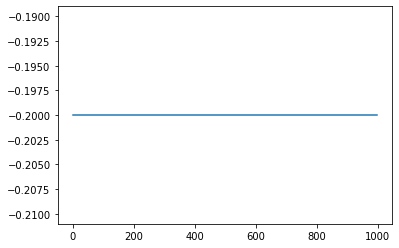

In [293]:
plt.plot(np.sum(velocities, axis=1)[:-1])

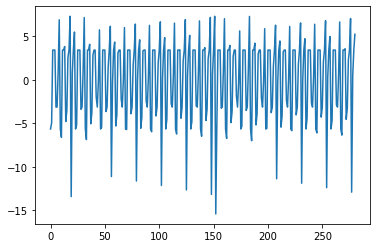

In [282]:
plt.plot(np.arange(numCells),chargedensities[89])

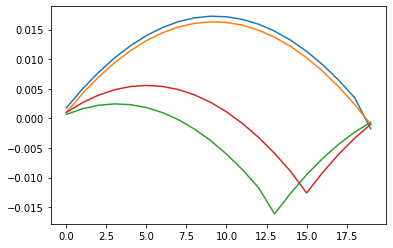

In [310]:
plt.plot(potentials[1])
plt.plot(potentials[3])
plt.plot(potentials[27])
plt.plot(potentials[189])

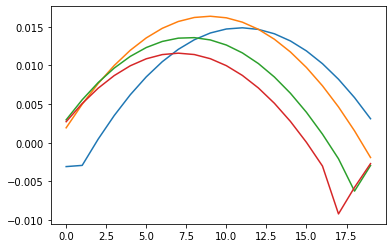

In [368]:
plt.plot(potentials[0])
plt.plot(potentials[3])
plt.plot(potentials[6])
plt.plot(potentials[9])

In [377]:
phi = potentials[891]
ch = np.zeros(numCells)
for i in np.arange(1,numCells-1):
    ch[i+1] = phi[i+1]+phi[i-1]-2*phi[i]
ch/=cellSize**2
ch*=-1
ch=np.concatenate([ ch])

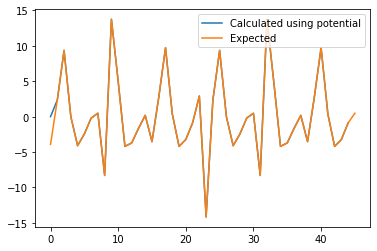

In [378]:
plt.plot(ch[1:])
plt.plot(chargedensities[891])
plt.legend(['Calculated using potential','Expected'])

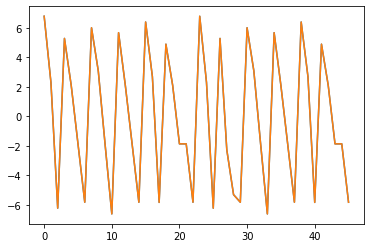

In [376]:
plt.plot(-potSolverMatrix@potentials[120]/cellSize**2)
plt.plot(chargedensities[120])

In [379]:
potSolverMatrix

array([[-2.,  1.,  0., ...,  0.,  0.,  0.],
       [ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.],
       [ 0.,  0.,  0., ...,  0.,  1., -2.]])

In [380]:
( np.diag(np.full(numCells-1, -.5*cellSize), 1)
                          + np.diag(np.full(numCells-1, .5*cellSize), -1))

array([[ 0.        , -0.01847826,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01847826,  0.        , -0.01847826, ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.01847826,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
        -0.01847826,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.01847826,
         0.        , -0.01847826],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01847826,  0.        ]])